In [1]:
# #@title Setup Runtime
#
# # install jax with cuda enabled
# !pip install "jax[cuda12]==0.5.1"
#
# # Install the necessary prerequisite libraries
# !sudo apt install -y libx11-dev libxrandr-dev libxinerama-dev libxcursor-dev libxi-dev mesa-common-dev
#
# # get madrona mjx and its subpackages
# !mkdir modules
# !git clone https://github.com/shacklettbp/madrona_mjx.git modules/madrona_mjx
# !git -C modules/madrona_mjx submodule update --init --recursive
#
# # prepare the build directory
# !mkdir modules/madrona_mjx/build
#
# # Build Madrona MJX
# !mkdir modules/madrona_mjx/build
# !cd modules/madrona_mjx/build && cmake -DLOAD_VULKAN=OFF .. && make -j 8
#
# # Install Madrona MJX
# !pip install -e modules/madrona_mjx
#
# # Clone and install our Quadruped RL package
# !git clone https://github.com/alexeiplatzer/unitree-go2-mjx-rl.git
# !pip install -e unitree-go2-mjx-rl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.2/105.2 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.7.2
    Uninstalling jax-cuda12-pjrt-0.7.2:
      Successfully uninstalled jax-cuda12-pjrt-0.7.2
  Attempting uninstall: jax-cuda12-plugin
    Found existing installation: jax-cuda12-plugin 0.7.2
    Uninstalling jax-cuda12-plugin-0.7.2:
      Successfully uninstalled jax-cuda12-plugin-0.7.2
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.7.2
    Uninstalling jaxlib-0.7.2:
      Successfully uninstalled jaxlib-0.7.2
  Attempting uninstall: jax
    Found existing installation: jax 0.7.2
    Uninstalling jax-0.7.2:
      Successfully uninstalled jax-0.7.2
ERROR: p

In [ ]:
# #@title Refresh the package
# repo_path = "./unitree-go2-mjx-rl"
# !git -C {repo_path} pull

Already up to date.


INFO:root:Logging switched on.


Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


""

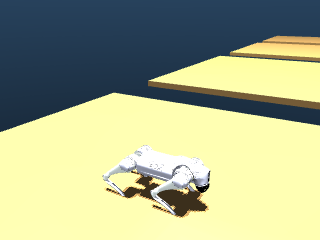

""

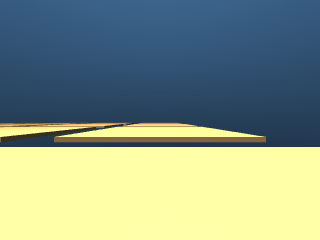

""

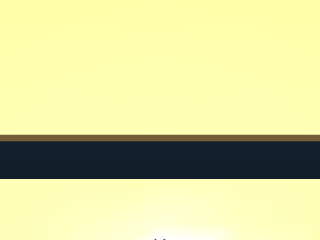

""

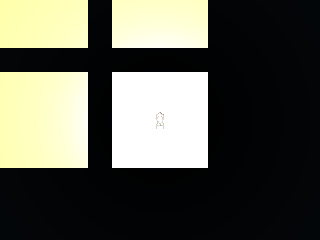

""

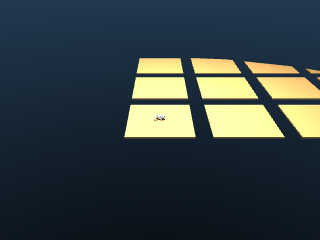

INFO:2025-11-16 11:34:38,551:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-11-16 11:34:38,556:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:root:Using JAX default device: TFRT_CPU_0.
INFO:root:No CUDA GPU devices found in jax.devices("cuda").
INFO:root:Using JAX default device: TFRT_CPU_0.
INFO:root:No CUDA GPU devices found in jax.devices("cuda").


Setup finished, initializing the environment...


INFO:root:Using JAX default device: TFRT_CPU_0.
INFO:root:No CUDA GPU devices found in jax.devices("cuda").


In [1]:
#@title Setup Session

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, force=True)
logging.info("Logging switched on.")

import os
# Ensure that Madrona gets the chance to pre-allocate memory before Jax
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# On your second reading, load the compiled rendering backend to save time!
use_madrona_cache = False #@param {"type":"boolean"}
if use_madrona_cache:
    os.environ["MADRONA_MWGPU_KERNEL_CACHE"] = "modules/madrona_mjx/build/cache"

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#     with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#         f.write("""{
#         "file_format_version" : "1.0.0",
#         "ICD" : {
#             "library_path" : "libEGL_nvidia.so.0"
#         }
#     }
#     """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
# xla_flags = os.environ.get('XLA_FLAGS', '')
# xla_flags += ' --xla_gpu_triton_gemm_any=True'
# os.environ['XLA_FLAGS'] = xla_flags

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Prepare paths
from pathlib import Path
# repo_path = Path("unitree-go2-mjx-rl")
robot_name = "unitree_go2"
# scenes_path = repo_path / "resources" / robot_name
# results_path = Path("results")
# results_path.mkdir(parents=True, exist_ok=True)
scenes_path = Path("/home/platzer/TUM/Thesis/unitree-go2-mjx-rl/resources") / robot_name

# Relevant imports
import functools
import mujoco

# Prepare robot config
from quadruped_mjx_rl.robots import predefined_robot_configs
robot_config = predefined_robot_configs[robot_name]()

# Prepare env config
from quadruped_mjx_rl.environments import QuadrupedVisionBaseEnvConfig
CameraConfig = QuadrupedVisionBaseEnvConfig.ObservationConfig.CameraInputConfig
env_config = QuadrupedVisionBaseEnvConfig(
    observation_noise=QuadrupedVisionBaseEnvConfig.ObservationConfig(
        camera_inputs=[
            CameraConfig("frontal_ego", True, True, True),
            CameraConfig("terrain", True, True, True),
        ]
    )
)

# Prepare the scene file
init_scene_path = scenes_path / "scene_mjx_empty_arena.xml"

# Prepare the terrain
from quadruped_mjx_rl.terrain_gen import load_to_spec, get_simple_tiled_terrain, spec_to_model
env_spec = load_to_spec(init_scene_path)
terrain_config = get_simple_tiled_terrain(n_rows=4, n_columns=4)
terrain_config.make_arena(env_spec)

# Add custom cameras
from quadruped_mjx_rl.terrain_gen.elements import add_robot_camera
add_robot_camera(
    spec=env_spec,
    robot_config=robot_config,
    name="high_above_cam",
    mode="fixed",
    location=[0.0, 0.0, 10.0],
    xyaxes=[0.0, -1.0, 0.0, 1.0, 0.0, 0.0],
    orthographic=True,
    fovy=10,
)
env_model = spec_to_model(env_spec)

# Render the environments from different cameras in mujoco
from quadruped_mjx_rl.environments.rendering import (
    render_model,
    show_image,
    large_overview_camera,
)
render_cam = functools.partial(
    render_model, env_model=env_model, initial_keyframe=robot_config.initial_keyframe
)
camera_list = [
    mujoco.mj_id2name(env_model, mujoco.mjtObj.mjOBJ_CAMERA, idx)
    for idx in range(env_model.ncam)
]
camera_list.append(large_overview_camera())
for camera in camera_list:
    camera_image = render_cam(camera=camera)
    show_image(camera_image)

# Prepare vision config
from quadruped_mjx_rl.environments.vision.robotic_vision import RendererConfig
num_envs=64 #@param {"type":"integer"}
enabled_cameras=[1, 2] #@param
enabled_cameras.append(
    mujoco.mj_name2id(env_model, mujoco.mjtObj.mjOBJ_CAMERA, "high_above_cam")
)
enabled_geom_groups=[0, 1, 2] #@param
render_width=64 #@param {"type":"integer"}
render_height=64 #@param {"type":"integer"}
vision_config = RendererConfig(
    render_batch_size=num_envs,
    enabled_cameras=enabled_cameras,
    enabled_geom_groups=enabled_geom_groups,
    render_width=render_width,
    render_height=render_height,
)

# Make the env factory
from quadruped_mjx_rl.environments import get_env_factory
from quadruped_mjx_rl.environments.vision.robotic_vision import get_renderer
renderer_maker = functools.partial(get_renderer, vision_config=vision_config, debug=True)
env_factory = get_env_factory(
    robot_config=robot_config,
    environment_config=env_config,
    env_model=env_model,
    customize_model=True,
    vision_config=vision_config,
    renderer_maker=renderer_maker,
)

# Create the environment
print("Setup finished, initializing the environment...")
env = env_factory()

In [ ]:
import mediapy as media
from quadruped_mjx_rl.environments.rendering import render_vision_observations
from quadruped_mjx_rl.domain_randomization.randomized_tiles import randomize_tiles

images = render_vision_observations(
    env=env, seed=0, domain_rand_fn=randomize_tiles, num_worlds=num_envs
)

for image in images:
    media.show_image(image, width=512)